<div class="span5 alert alert-info">
<h1>Data Science Salaries (ML Code)</h1>
</div>

In [59]:
import os
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score
from sklearn.utils.multiclass import unique_labels

import warnings
warnings.filterwarnings('ignore')

In [2]:
"""For Aesthetics"""

font = {'family' : 'normal',
        'size'   : 20}
mpl.rc('font', **font)

mpl.rcParams['figure.figsize'] = (15.0, 5.0)

<div class="span5 alert alert-info">
<h2>Data taken from the 2018 Kaggle Data Science survery in this notebook is limited to those who: </h2>

<h3> (1) live in the USA, </h3>
    
<h3> (2) share their salary details, and </h3>

<h3> (3) are employed as Data Scientists </h3>

</div>

In [3]:
df = pd.read_csv("/Users/victor/Downloads/kaggle-survey-2018/multipleChoiceResponses.csv",skiprows=1)

# 1
df = df.loc[df["In which country do you currently reside?"]=="United States of America"]

# Cleaning up the labels
df = df.iloc[:,[1,3,5,6,7,9,11,12]]

df.columns = ["Gender","Age","Education","Major",
              "Occupation","Industry","Experience",
              "Salary"]

In [4]:
# 2 and 3
df = df.dropna(subset=['Salary'])
df = df[~df.isin(['I am a student', 
                  'I do not wish to disclose my approximate yearly compensation',
                  'Student',
                  'Not employed']).any(axis=1)]

In [5]:
df = df[(df.Occupation=="Data Scientist")]

In [6]:
df = df.fillna("Unknown")

<div class="span5 alert alert-info">
<h2> Feature engineering </h2>
</div>

In [7]:
# Salary
dictionary = {'0-10,000'    : 5000,
              '10-20,000'   : 15000,
              '20-30,000'   : 25000,
              '30-40,000'   : 35000,
              '40-50,000'   : 45000,
              '50-60,000'   : 55000,
              '60-70,000'   : 65000,
              '70-80,000'   : 75000,
              '80-90,000'   : 85000,
              '90-100,000'  : 95000,
              '100-125,000' : 112500,
              '125-150,000' : 137500,
              '150-200,000' : 175000,
              '200-250,000' : 225000,
              '250-300,000' : 275000,
              '300-400,000' : 350000,
              '400-500,000' : 450000,
              '500,000+'    : 500000
             }
df['Sal_Mid'] = df.Salary.apply(lambda x: dictionary[x])    
                    
# Age
dictionary = {'18-21' : 19.5,
              '22-24' : 23,
              '25-29' : 27,
              '30-34' : 32,
              '35-39' : 37,
              '40-44' : 42,
              '45-49' : 47,
              '50-54' : 52,
              '55-59' : 57,
              '60-69' : 64.5,
              '70-79' : 74.5,
              '80+'   : 80
             }
df['Age_Mid'] = df['Age'].apply(lambda x: dictionary[x])

# Experience
dictionary = {'0-1'    : .5,
              '1-2'    : 1.5,
              '2-3'    : 2.5,
              '3-4'    : 3.5,
              '4-5'    : 4.5,
              '5-10'   : 7.5,
              '10-15'  : 12.5,
              '15-20'  : 17.5,
              '20-25'  : 22.5,
              '25-30'  : 27.5,
              '30 +'   : 30
            }
df['Exp_Mid'] = df['Experience'].apply(lambda x: dictionary[x])

# 1,0 target column
df['Sal_Lor'] = df.Sal_Mid > df.Sal_Mid.median()

<div class = "span5 alert alert-info">
    <h2> Reordering the columns and removing/merging small subgroups </h2>
    </div>

In [8]:
df = df[["Gender","Education","Major","Industry","Age",
         "Experience","Salary","Age_Mid","Exp_Mid","Sal_Mid"]]

In [9]:
df = df[(df.Gender=="Male") | 
         (df.Gender=="Female")
        ]

# the apostrophes used below are not the standard ones used on a keyboard
# I copy and pasted the bachelors and masters text below from a value_counts print
df = df[(df.Education=="Bachelor’s degree") | 
          (df.Education=="Master’s degree") |
          (df.Education=="Doctoral degree")
         ]

In [10]:
dictionary = {'Master’s degree'    : "Master", 
              'Bachelor’s degree'  : "Bachelor",
              'Doctoral degree'    : "Doctoral"
             }
df.Education = df.Education.apply(lambda x: dictionary[x])

dictionary = {'Social sciences (anthropology, psychology, sociology, etc.)'   : 'Social Sci',
              'Mathematics or statistics'                                     : 'Math/Stats', 
              'Engineering (non-computer focused)'                            : 'Engineering',
              'Computer science (software engineering, etc.)'                 : 'Comp Sci',
              'Physics or astronomy'                                          : 'Phys/Astron',
              'A business discipline (accounting, economics, finance, etc.)'  : 'Business',
              'Medical or life sciences (biology, chemistry, medicine, etc.)' : 'Medic Sci',
              'Fine arts or performing arts'                                  : 'Other',
              'Information technology, networking, or system administration'  : 'Other',
              'Environmental science or geology'                              : 'Other', 
              'Other'                                                         : 'Other',
              'Humanities (history, literature, philosophy, etc.)'            : 'Other',
              'I never declared a major'                                      : 'Other',
              'Unknown'                                                       : 'Other'
             }
df['Major'] = df['Major'].apply(lambda x: dictionary[x])

dictionary = {'Other'                                  : "Other",
              'Marketing/CRM'                          : "Marketing", 
              'Insurance/Risk Assessment'              : "Risk_Asse",
              'Computers/Technology'                   : "Technology", 
              'Broadcasting/Communications'            : "Other",
              'Academics/Education'                    : "Other", 
              'Accounting/Finance'                     : "Finance",
              'Medical/Pharmaceutical'                 : "Medical", 
              'Non-profit/Service'                     : "Other",
              'Online Service/Internet-based Services' : "Online_Serv",
              'Shipping/Transportation'                : "Other", 
              'Energy/Mining'                          : "Other", 
              'Retail/Sales'                           : "Other" ,
              'Military/Security/Defense'              : "Other",
              'Online Business/Internet-based Sales'   : "Other",
              'Manufacturing/Fabrication'              : "Other", 
              'Government/Public Service'              : "Government",
              'Hospitality/Entertainment/Sports'       : "Other"
             }
df['Industry'] = df['Industry'].apply(lambda x: dictionary[x])  
                    
#Age
dictionary = {'18-21' : "Other",
              '22-24' : '22-24',
              '25-29' : '25-29',
              '30-34' : '30-34',
              '35-39' : '35-39',
              '40-44' : '40-44',
              '45-49' : '45-49',
              '50-54' : "Other",
              '55-59' : "Other",
              '60-69' : "Other",
              '70-79' : "Other",
              '80+'   : "Other"
             }
df['Age'] = df['Age'].apply(lambda x: dictionary[x])

#Experience for linear regession
dictionary = {'0-1'    : '0-1',
              '1-2'    : '1-2',
              '2-3'    : '2-3',
              '3-4'    : '3-4',
              '4-5'    : '4-5',
              '5-10'   : '5-10',
              '10-15'  : '>10',
              '15-20'  : '>10',
              '20-25'  : '>10',
              '25-30'  : '>10',
              '30 +'   : '>10'
            }
df['Experience'] = df['Experience'].apply(lambda x: dictionary[x])

#For logistic regression
df['Sal_Binary'] = df.Sal_Mid > df.Sal_Mid.median()

<div class = "span alert alert-info">
    <h1> Class with various Methods for Binary Classification </h1>
    </div>

In [62]:
class Classification:
    def __init__(self, x, y, scoring="roc_auc", train_size=0.7, n_folds=5, standardize=False): 
        self.x = x #features df
        self.y = y #target df
        self.scoring = scoring #example: "accuracy", "f1", "roc_auc"
        self.train_size = train_size
        self.n_folds = n_folds
        self.standardize = standardize
        self.x_train, self.x_test, self.y_train, self.y_test = \
        train_test_split(self.x, self.y, train_size=self.train_size, random_state=0)
    
    """ 
    examine_model has two functions within it:
    (1) model_and_grid = using a model name, it returns a model and its cvgrid
    (2) best_model = using model_and_grid, it generates a model with best hyperparameters
    """
    def examine_model(self, model_name):
        
        def model_and_grid(model_name):
            if model_name == "log_reg":
                model = LogisticRegression()
                grid = {'C' : [0.001, 0.1, 1, 10, 100]}
                return model, grid

            elif model_name == "ran_for":
                model = RandomForestClassifier(random_state=0)
                grid = {'n_estimators' : [1, 30], 
                        'max_features' : ['auto', 'log2'],  
                        'max_depth' : [ 3, 5, 7, 10, 12, 15], 
                        'criterion' : ['gini', 'entropy']}
                return model, grid

            elif model_name == "knn":
                model = KNeighborsClassifier()
                grid = {"n_neighbors" : [3,6,9,12]}
                return model, grid

            elif model_name == "xgb":
                model = XGBClassifier()
                grid = { 
                          "max_depth"         : [2, 4, 8, 16],
                          "alpha"             : [10, 20, 30],
                          "lambda"            : [10, 20, 30],
        #                  "min_child_weight" : [  1,  5],
        #                  "colsample_bytree" : [ .3, .7],
        #                  "learning_rate"    : [.10, .30],
        #                  "gamma"            : [  0, .5, 5],
        #                  "eta"              : [0.05, 0.20]
                }  
                return model, grid

            elif model_name == "gnb":
                model = GaussianNB()
                grid = {"var_smoothing" : [1e-01, 1e-05, 1e-09, 1e-15]}
                return model, grid
        
        def best_model(model, grid):
            gs = GridSearchCV(model, param_grid=grid, cv=self.n_folds, scoring=self.scoring)
            gs.fit(self.x_train, self.y_train)
            print("CV " + self.scoring.upper() + " SCORE:", round(gs.best_score_,3))
            print("CV PARAMS: ", gs.best_params_)
            #print("BEST MODEL: ", gs.best_estimator_)
            best_model = gs.best_estimator_
            return best_model

        model, grid = model_and_grid(model_name)
        best_mod = best_model(model, grid)
        return best_mod

    def compare_models(self):
        z = 0
        mods = ["log_reg", "knn", "ran_for", "gnb", "xgb"]
        for name in mods:
            print("*** " + mods[z] + " ***")
            self.examine_model(name)
            print("")
            z += 1
            
    def test_scores(self, model_name, detail=True, all_metrics=True, show_test=True): 
        model = self.examine_model(model_name)
        y_pred_train = model.predict(self.x_train)
        y_pred_test = model.predict(self.x_test)
        y_prob_train = model.predict_proba(self.x_train)[:,1]
        y_prob_test = model.predict_proba(self.x_test)[:,1]

        """ F1 (f-one) Score """
        ## F1 Score = 2*((precision*recall)/(precision+recall))
        if self.scoring == "f1" or all_metrics:
            f1_train = metrics.f1_score(self.y_train, y_pred_train)
            print("\nF1 on training data:{:0.2f}".format(f1_train))

            if show_test:
                f1_test = metrics.f1_score(self.y_test, y_pred_test)
                print("F1 on test data:{:0.2f}".format(f1_test))

        """ Accuracy """
        ## number of correct predictions made / total number of predictions made
        ### accuracy is not always the best metric: https://en.wikipedia.org/wiki/Accuracy_paradox
        if self.scoring == "accuracy" or all_metrics:
            accuracy_training = model.score(self.x_train, self.y_train)
            print("Accuracy on training data:{:0.2f}".format(accuracy_training))

            if show_test:
                accuracy_test = model.score(self.x_test, self.y_test)
                print("Accuracy on test data:{:0.2f}".format(accuracy_test))

        """ ROC AUC """
        ## How well model distinguishs between classes
        ### Higher the AUC, better the model is at predicting 0 as 0 and 1 as 1
        #### https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5
        if self.scoring == "roc_auc" or all_metrics:
            roc_auc_score_training = roc_auc_score(self.y_train, y_prob_train)
            print("ROC AUC on training data:{:0.2f}".format(roc_auc_score_training))

            if show_test:
                roc_auc_score_test = roc_auc_score(self.y_test, y_prob_test)
                print("ROC AUC on test data:{:0.2f}\n".format(roc_auc_score_test))

            if not show_test:
                print("")

        if detail:
            """ Confusion matrix """
            """     P   N     <- actual
                P  TP  FP 
                N  FN  TN   """
            c_matrix = confusion_matrix(self.y_test, y_pred_test)
            print("Confusion Matrix on test data:\n", c_matrix)

            """ Classification Report """
            ## Precision = TP / TP + FP
            ### Also known as Positive Predictive Value
            ## Recall = TP/ TP + FN
            class_repo = classification_report(self.y_test,y_pred_test)
            print("\nClassification Report on test data:\n", class_repo)

            try:
                # Coefficients
                coefs = pd.Series(model.coef_[0], index=self.x.columns)
                coefs = coefs.sort_values()
                coefs.plot(kind="bar",title="Coefficients")
                #plt.xticks(fontsize=20)
                #plt.yticks(fontsize=20)
                plt.show()
                #print(coefs.sort_values(ascending = False))
            except: 
                print("No coefficients need to be fitted by optimization procedure")

            #Plot ROC curve
            fpr, tpr, thresholds = roc_curve(self.y_test, y_prob_test)
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr, tpr)
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curve')
            plt.show()
            print("")    
                
            # Threshold Plot
            precision, recall, thresholds = precision_recall_curve(self.y_test, y_prob_test)
            f1 = []
            acc = []
            roc = []
            avg_pr = []

            def adjust_pred_prob(y_prob_test, new_threshold):
                return [1 if prob >= new_threshold else 0 for prob in y_prob_test]

            for t in thresholds:
                adjusted_y_pred = adjust_pred_prob(y_prob_test, t)
                add_f1 = metrics.f1_score(self.y_test, adjusted_y_pred)
                f1.append(add_f1)
                
            for t in thresholds:
                adjusted_y_pred = adjust_pred_prob(y_prob_test, t)
                add_acc = accuracy_score(self.y_test, adjusted_y_pred)
                acc.append(add_acc)
                
            for t in thresholds:
                adjusted_y_pred = adjust_pred_prob(y_prob_test, t)
                add_avg_pr = average_precision_score(self.y_test, adjusted_y_pred)
                avg_pr.append(add_avg_pr)
                
#             ## Retrieve probability of being 1(in second column of probs_y)
#             pr_auc = metrics.auc(recall, precision)

            plt.title("Precision-Recall-Accuracy vs Threshold")
            plt.plot(thresholds, precision[: -1], "b-", label="Precision")
            plt.plot(thresholds, recall[: -1], "r-", label="Recall")
            #plt.plot(thresholds, avg_pr, "k-", label="Average Precision Recall")
            #plt.plot(thresholds, f1, "k-", label="F1_Score")
            plt.plot(thresholds, acc, "g-", label="Accuracy")
            
            max_acc_x = thresholds[np.argmax(acc)]
            plt.axvline(x=max_acc_x, ymin=0.00, ymax=max(acc), color='g', linestyle='-')
            #plt.axhline(y=max(acc), color='g', linestyle='--')
            #plt.text(max_acc_x, max(acc), ("Max Accuracy " + str(round(max_acc_x,2))), rotation=90)
            
            #max_f1_x = thresholds[np.argmax(f1)]
            #plt.axvline(x=max_f1_x, color='k', linestyle='--')
            #plt.axhline(y=max(f1), color='k', linestyle='--')
            #plt.text(max_f1_x, max(f1), ("Max F1 Score " + str(round(max_f1_x,2))), rotation=90)
                        
            plt.ylabel("Score")
            plt.xlabel("Threshold")
            
            #plt.text(intersect_x, intersect_y, 'PR Intersect', rotation=90)
            plt.legend(loc="lower left")
            plt.ylim([0,1])
            plt.show()
            print("Maximum Accuracy: " + str(round(max(acc),2)) + " @ Threshold: " + str(round(max_acc_x,2)))
            #print("Maximum F1 Score: " + str(round(max(f1),2)) + " @ Threshold: " + str(round(max_f1_x,2)))
            
            """ 
            Varying Fscore's beta vs Varying Thresholds
            
            The beta parameter determines the weight of recall in the combined score. 
            beta < 1 lends more weight to precision, while 
            beta > 1 favors recall 
            (beta -> 0 considers only precision, beta -> inf only recall).
            """

            f025 = []
            f050 = []
            f075 = []
            f100 = []
            f125 = []
            f150 = []
            f200 = []

            def fbeta_testing(beta, fxxx):
                for t in thresholds:
                    adjusted_y_pred = adjust_pred_prob(y_prob_test, t)
                    add_fbeta = metrics.fbeta_score(self.y_test, adjusted_y_pred, beta)
                    fxxx.append(add_fbeta)

            betas = [0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 2.00]
            flist = [f025, f050, f075, f100, f125, f150, f200]

            z = 0
            for beta in betas:
                fbeta_testing(beta, flist[z])
                z += 1

            plt.title("F_Beta_Score vs Threshold: Varying Betas")
            #plt.plot(thresholds, f025, "r-", label="F0.25")
            plt.plot(thresholds, f050, "m-", label="F0.50")
            #plt.plot(thresholds, f075, "g-", label="F0.75")
            plt.plot(thresholds, f100, "c-", label="F1.00")
            #plt.plot(thresholds, f125, "b-", label="F1.25")
            #plt.plot(thresholds, f150, "k-", label="F1.50")
            plt.plot(thresholds, f200, "y-", label="F2.00")
            #plt.axvline(.425, color='k', linestyle='--')
            #plt.axvline(.45, color='k', linestyle='-')
            
            max_f050_x = thresholds[np.argmax(f050)]
            plt.axvline(x=max_f050_x, ymin=0.00, ymax=max(f050), color='m', linestyle='-')
            max_f100_x = thresholds[np.argmax(f100)]
            plt.axvline(x=max_f100_x,ymin=0.00, ymax=max(f100), color='c', linestyle='-')
            max_f200_x = thresholds[np.argmax(f200)]
            plt.axvline(x=max_f200_x, ymin=0.00, ymax=max(f200), color='y', linestyle='-')
            
            plt.ylabel("F_Beta_Score")
            plt.xlabel("Threshold")
            plt.legend(loc="lower left")
            plt.ylim([0,1])
            plt.show()
            
            print("Maximum F0.5 Score: " + str(round(max(f050),2)) + " @ Threshold: " + str(round(max_f050_x,2)))
            print("Maximum F1   Score: " + str(round(max(f100),2)) + " @ Threshold: " + str(round(max_f100_x,2)))
            print("Maximum F2.0 Score: " + str(round(max(f200),2)) + " @ Threshold: " + str(round(max_f200_x,2)))

            """ Threshold = 0.5, varying fscore's beta """

            betas = [0.25,0.50,0.75,1.00,1.25,1.50,2.00]
            fbetas = []

            for beta in betas:
                score = fbeta_score(self.y_test, y_pred_test, beta=beta)
                fbetas.append(score)    

#             plt.title("F_Score vs Beta: Threshold = 0.5")
#             plt.plot(betas, fbetas[:], "g--")
#             plt.ylabel("F-Score")
#             plt.xlabel("Beta")
#             plt.show()

            #         """ Confusion Matrix as Threshold Varies """

            #         # Range of Values for Thresholds
            #         pred_proba_df = pd.DataFrame(model.predict_proba(x_test))
            #         Y_test = pd.DataFrame(y_test)
            #         threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,
            #0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
            #         for i in threshold_list:
            #             print ('\n******** For Threshold = {} ******'.format(i))
            #             Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
            #             test_accuracy = metrics.accuracy_score(Y_test.as_matrix().reshape(
            #Y_test.as_matrix().size,1),
            #                                               Y_test_pred.iloc[:,1].as_matrix().reshape(
            #                                                   Y_test_pred.iloc[:,1].as_matrix().size,1))

            #             print('Testing accuracy: {}'.format(test_accuracy))

            #             print(confusion_matrix(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
            #                               Y_test_pred.iloc[:,1].as_matrix().reshape(
            #Y_test_pred.iloc[:,1].as_matrix().size,1)))

    def best_features(self, model_name, max_features=100):
        model = self.examine_model(model_name)
        df = pd.concat([self.x_train, self.y_train], axis=1)
        candidate_features = list(self.x_train.columns)
        target = list(self.y_train.columns)
        
        def next_best(model, current_features, candidate_features, target, df, scoring): 
            best_metric = -1
            best_feature = None
            for feature in candidate_features:
                metric_feature = metric_choice(model, current_features, feature, target, df, scoring)
                if metric_feature >= best_metric: 
                    best_metric = metric_feature
                    best_feature = feature
            return best_feature
    
        def metric_choice(model, current_features, feature, target, df, scoring):
            x = df[current_features + [feature]]
            y = df[target]
            model.fit(x, y)
            y_pred = model.predict(x) 
            y_prob = model.predict_proba(x)[:,1] 

            if scoring == "roc_auc":
                auc = roc_auc_score(y, y_prob) 
                return auc 

            elif scoring == "accuracy":
                acc = accuracy_score(y, y_pred) 
                return acc

            elif scoring == "f1":
                f1 = metrics.f1_score(y, y_pred) 
                return f1
        
        current_features = []
        number_iterations = min(max_features, len(candidate_features)) 
        for i in range(0,number_iterations):
            next_feature = next_best(model, current_features, candidate_features, target, df, self.scoring)
            current_features = current_features + [next_feature] 
            candidate_features.remove(next_feature)
        return model, current_features
    
    def feature_vs_metric(self, model_name):
        model, current_features = self.best_features(model_name)
        metric_values_train = []
        features_evaluate = []
        
        def metric_tra(model, x, y, metric):
            model.fit(x,y)

            y_pred = model.predict(x)
            y_proba = model.predict_proba(x)[:,1]

            if metric == "f1":
                metric_train = metrics.f1_score(y, y_pred)
                return metric_train

            if metric == "accuracy":
                metric_train = model.score(x, y)
                return metric_train

            if metric == "roc_auc":
                metric_train = roc_auc_score(y, y_proba)
                return metric_train

        for feature in current_features:
            features_evaluate.append(feature)
            metric_train = metric_tra(model, self.x_train[features_evaluate], self.y_train, self.scoring)
            metric_values_train.append(metric_train)

        # Plot of metric values
        x_plot = np.array(range(0,len(metric_values_train)))
        y_train = np.array(metric_values_train)
        plt.xticks(x_plot, current_features, rotation = 90)
        plt.plot(x_plot,y_train)
        
        global max_score
        max_score = np.argmax(y_train)
        
        plt.axvline(x=max_score, color='k', linestyle='--')
        plt.axhline(y=max(y_train), color='k', linestyle='--')
        plt.text(max_score, (max(y_train)*1.09), 'Max Score', rotation=90)
        
        plt.title(self.scoring.upper() + " vs Features")
        plt.xlabel("Features")
        plt.ylabel(self.scoring.upper() + " Score")
        plt.ylim(((max(y_train) - .10), (max(y_train) + .10)))
        plt.show()

<div class = "span alert alert-info">
    <h1> User Defined Functions </h1>
    </div>

In [12]:
""" For checking which features are most correlated """

def get_redundant_pairs(df):
    # Get diagonal and lower triangular pairs of correlation matrix
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def over_50perc_corr(df):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    tops = au_corr[au_corr > 0.50] 
    return tops

<div class = "span alert alert-success">
    <h1> Machine Learning </h1>
    </div>

In [13]:
# Check if the data is imbalanced
print(df.Sal_Binary.value_counts())
# balanced

print("")

# Checking the exact value of median
print(df.Sal_Mid.median())
# median DS salary is $112,500

False    437
True     314
Name: Sal_Binary, dtype: int64

112500.0


<div class = "span alert alert-warning">
    <h1> Roc_Auc score will be used as the scoring metric to compare 5 binary classification models </h1>
    </div>

In [14]:
x = pd.get_dummies(df[['Gender', 'Age', 'Education', 'Major', 'Industry', 'Experience']])
y = df[['Sal_Binary']]

Classification(x,y).compare_models()

*** log_reg ***
CV ROC_AUC SCORE: 0.729
CV PARAMS:  {'C': 0.1}

*** knn ***
CV ROC_AUC SCORE: 0.677
CV PARAMS:  {'n_neighbors': 12}

*** ran_for ***
CV ROC_AUC SCORE: 0.708
CV PARAMS:  {'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 30}

*** gnb ***
CV ROC_AUC SCORE: 0.734
CV PARAMS:  {'var_smoothing': 0.1}

*** xgb ***
CV ROC_AUC SCORE: 0.704
CV PARAMS:  {'alpha': 10, 'lambda': 10, 'max_depth': 2}



<div class = "span alert alert-warning">
    <h1> Best Roc_Auc score on the cross-validated (n_folds=5) training set was gaussian naive bayes; next step is to check how features affect the score </h1>
    </div>

CV ROC_AUC SCORE: 0.734
CV PARAMS:  {'var_smoothing': 0.1}


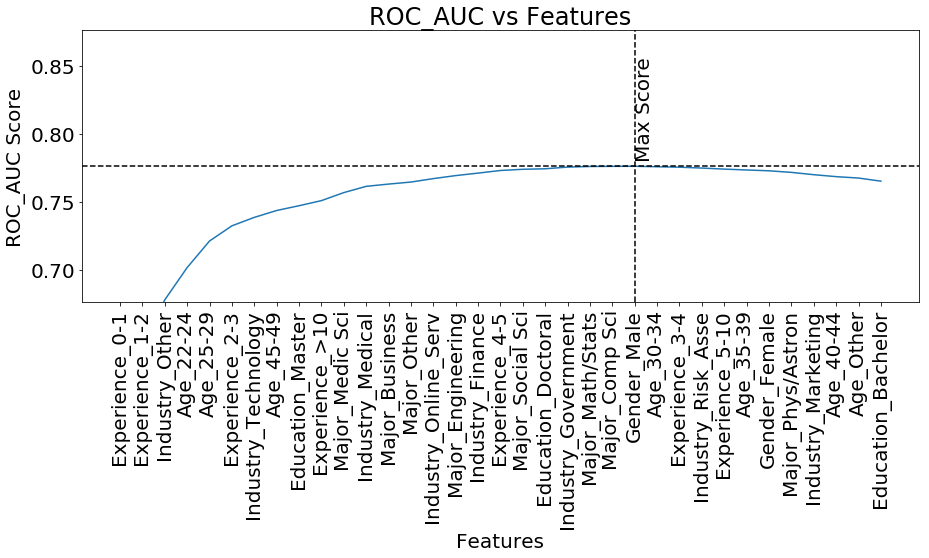

In [15]:
Classification(x,y).feature_vs_metric("gnb")

<div class = "span alert alert-warning">
    <h1> Any feature after "Max Score" is lowering the algorithm's ability to predict correctly; those features will be removed </h1>
    </div>

CV ROC_AUC SCORE: 0.734
CV PARAMS:  {'var_smoothing': 0.1}

CV ROC_AUC SCORE: 0.75
CV PARAMS:  {'var_smoothing': 0.1}


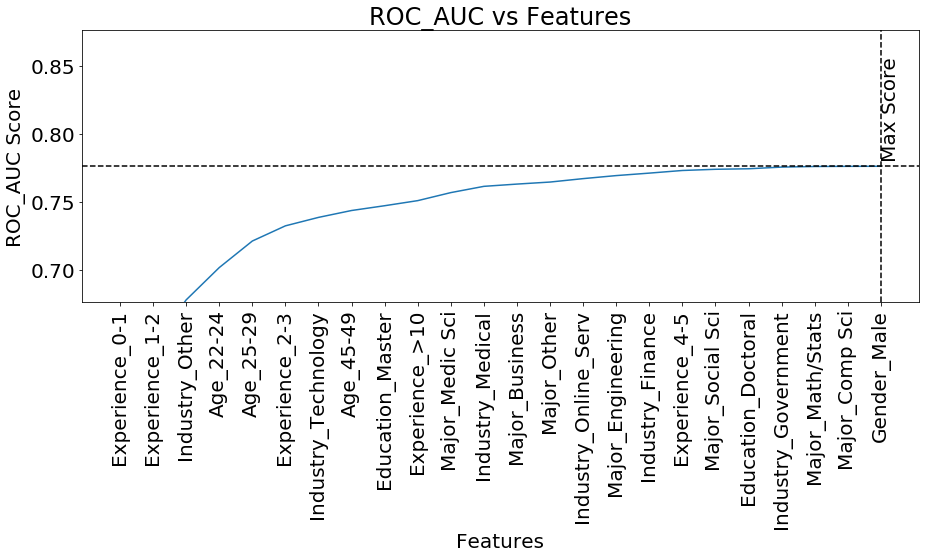

In [16]:
model, current_features = Classification(x,y).best_features("gnb")
x2 = x[current_features[:(max_score + 1)]]

print("")

Classification(x2,y).feature_vs_metric("gnb")

<div class = "span alert alert-warning">
    <h1> ROC_AUC score incresed to 75%.
        Next: Check if features with high correlation (>50%) exist and can be removed</h1>
    </div>

In [17]:
corr_df = pd.concat([x2,y], axis=1)

over_50perc_corr(corr_df)

Education_Master  Education_Doctoral    0.700075
dtype: float64

CV ROC_AUC SCORE: 0.75
CV PARAMS:  {'var_smoothing': 0.1}

CV ROC_AUC SCORE: 0.748
CV PARAMS:  {'var_smoothing': 0.1}


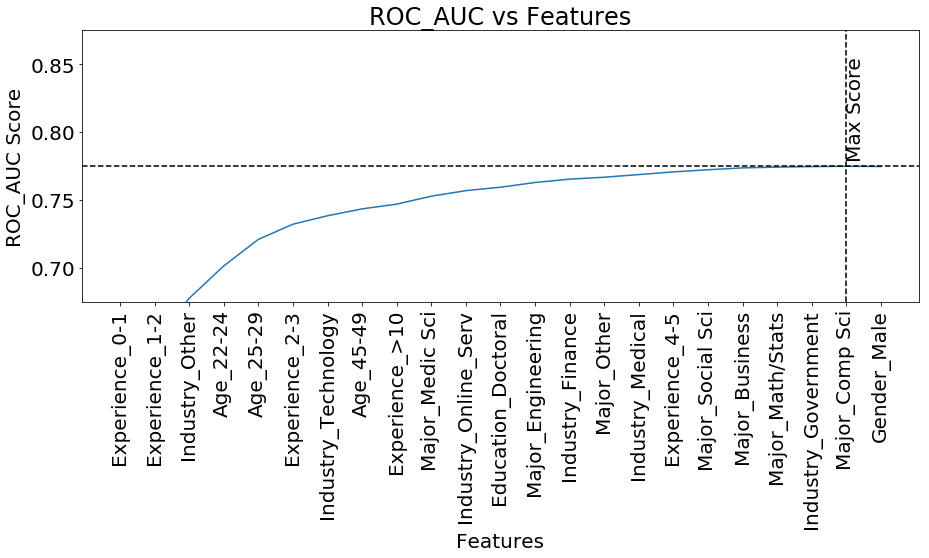

In [18]:
model, current_features = Classification(x2,y).best_features("gnb")
x3 = x2[current_features[:(max_score + 1)]].drop("Education_Master",axis=1)

print("")

Classification(x3,y).feature_vs_metric("gnb")

<div class = "span alert alert-warning">
    <h1> Removing Education_Master which was correlated with Education_Doctoral (70%) hurt the score negligibly. As well, Gender_Male is now identifed as unnecessary; these two features will not be used.</h1>
    </div>

CV ROC_AUC SCORE: 0.748
CV PARAMS:  {'var_smoothing': 0.1}
CV ROC_AUC SCORE: 0.75
CV PARAMS:  {'var_smoothing': 0.1}


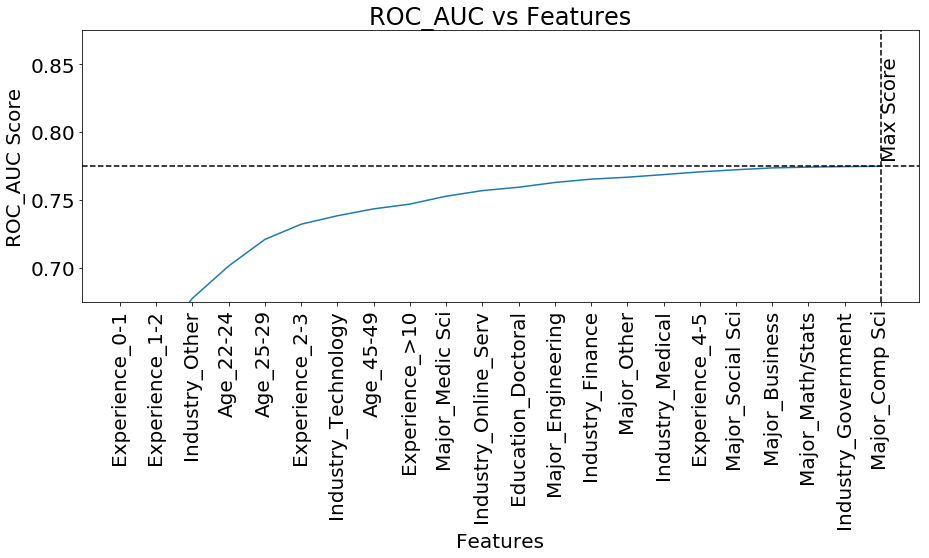

In [19]:
model, current_features = Classification(x3,y).best_features("gnb")
x4 = x3[current_features[:(max_score + 1)]]

Classification(x4,y).feature_vs_metric("gnb")

<div class = "span alert alert-warning">
    <h1> Removing Education_Master and Gender_Male brought the score back to 75% 
    (equivalent to x2). That is, with less features, the same roc_auc score was attained.
    This is good.</h1>
    </div>

CV ROC_AUC SCORE: 0.75
CV PARAMS:  {'var_smoothing': 0.1}

F1 on training data:0.63
F1 on test data:0.64
Accuracy on training data:0.73
Accuracy on test data:0.71
ROC AUC on training data:0.77
ROC AUC on test data:0.79

Confusion Matrix on test data:
 [[102  21]
 [ 44  59]]

Classification Report on test data:
               precision    recall  f1-score   support

       False       0.70      0.83      0.76       123
        True       0.74      0.57      0.64       103

   micro avg       0.71      0.71      0.71       226
   macro avg       0.72      0.70      0.70       226
weighted avg       0.72      0.71      0.71       226

No coefficients need to be fitted by optimization procedure


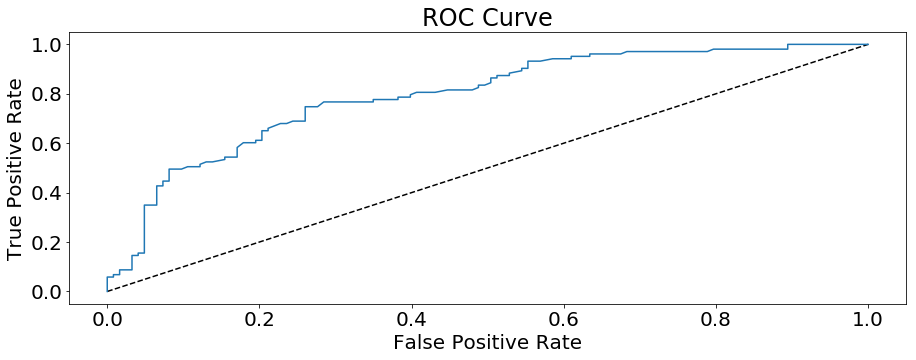

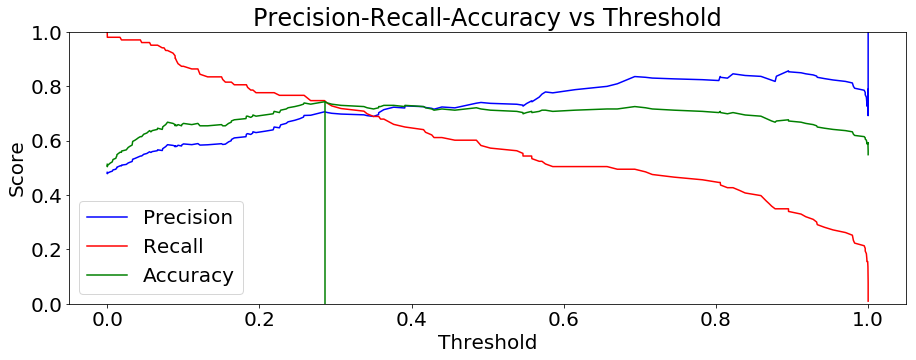

Maximum Accuracy: 0.74 @ Threshold: 0.29


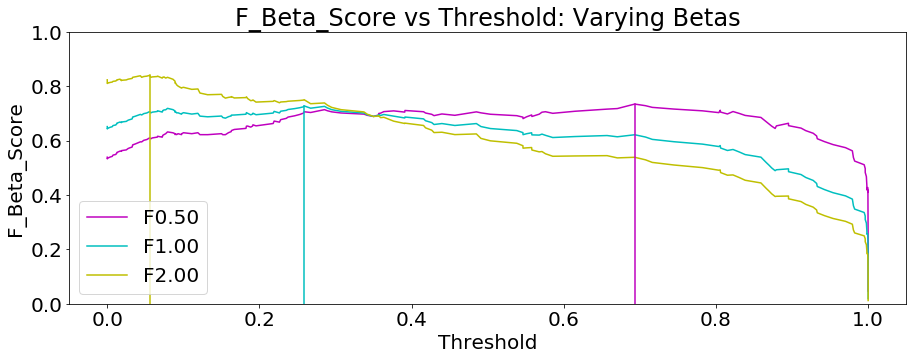

Maximum F0.5 Score: 0.73 @ Threshold: 0.69
Maximum F1   Score: 0.73 @ Threshold: 0.26
Maximum F2.0 Score: 0.84 @ Threshold: 0.06


In [63]:
Classification(x4,y).test_scores("gnb")

CV ROC_AUC SCORE: 0.75
CV PARAMS:  {'var_smoothing': 0.1}


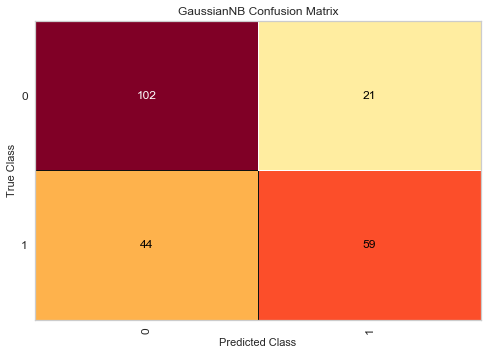

In [64]:
from yellowbrick.classifier import ConfusionMatrix

model, current_features = Classification(x4,y).best_features("gnb")

x_train, x_test, y_train, y_test = \
        train_test_split(x4, y, train_size=0.7, random_state=0)

# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(model, classes=[0,1])

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(x_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(x_test, y_test)

# How did we do?
cm.poof()

<div class = "span alert alert-warning">
    <h1> 
    The final model yields a comparable ROC AUC, Accuracy, and F1 score on the test data. 
    To further improve a specific parameter, the threshold used for the desired F beta can 
        be specified (i.e., give more/less weight to precision or recall.)
    </h1>
    <h1>
        As well, the hyperparameters of each model can have its ranges expanded 
    or (in somes cases) have the number of hyperparameters increased. 
        Increasing ranges and number of hyperparameters typically becomes 
    computationally expensive (i.e., models take much longer to run).
    </h1>
    <h1> Additionally, feature engineering may also lead to better scores. 
        Finally, because this is classification, the voting ensemble method 
        may also lead to a better scores.
    </h1>
    </div>